In [47]:
import pandas as pd
import numpy as np
import torch
from torchvision import transforms
from fastai.vision.all import (
    get_image_files,
    first,
    parent_label,
    to_cpu,
    untar_data,
    CategoryBlock,
    DataBlock,
    GrandparentSplitter,
    ImageBlock,
    Path,
    PILImageBW,
    URLs,
)
from fastai.vision.widgets import Image
from fastbook import show_image
from torch import tensor


## The magic of convolutions


In an image a feature is a visually distinctive attribute. What if we could extract information about where the edges occur in each image and then use that information as our features, instead of raw pixels?

To find the edges in an image we used convolutions. A convolution requires nothing more than multiplicatio and addition.

A convolution applies a kernel across an image. A kernel is a little matrix.

![](images/conv_basic.png)


**Example with code using a picture from MNIST dataset**

In [2]:
# define kernel

top_edge_filter = tensor([
    [-1, -1, -1],
    [0, 0, 0],
    [1, 1, 1]
]).float()

top_edge_filter

tensor([[-1., -1., -1.],
        [ 0.,  0.,  0.],
        [ 1.,  1.,  1.]])

In [3]:
path = untar_data(URLs.MNIST_SAMPLE)
Path.BASE_PATH = path

In [4]:
im3 = Image.open(path/"train"/"3"/"12.png")
display(im3)

Now we're going to take the top 3×3-pixel square of our image, and multiply each of those values by each item in our kernel. Then we'll add them up

In [12]:
to_tensor_fn = transforms.ToTensor()

im3_t = to_tensor_fn(im3)[0]
im3_t[0:3,0:3] * top_edge_filter

tensor([[-0., -0., -0.],
        [0., 0., 0.],
        [0., 0., 0.]])

In [13]:
# it will be 0, because that area of the image is all white backgroud
(im3_t[0:3,0:3] * top_edge_filter).sum()

tensor(0.)

In [16]:
# check visually where we have black pixels to apply the filther somewhere there
df = pd.DataFrame(im3_t[:10,:20])
df.style.set_properties(**{"font-size": "6pt"}).background_gradient("Greys")

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.047059,0.388235,0.356863,0.556863,0.607843,0.964706,0.713726,0.607843,0.607843,0.607843,0.607843,0.513726,0.203922,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.541176,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.988235,0.823529,0.478431,0.129412,0.000000
7,0.000000,0.000000,0.000000,0.862745,0.996078,0.996078,0.996078,0.921569,0.741176,0.741176,0.741176,0.741176,0.588235,0.741176,0.803922,0.996078,0.996078,0.996078,0.294118,0.000000
8,0.000000,0.000000,0.000000,0.137255,0.290196,0.137255,0.137255,0.098039,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.050980,0.878431,0.996078,0.996078,0.600000,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.352941,0.996078,0.996078,0.968627,0.207843,0.000000


In [17]:
# There's a top edge at cell 5,8. Let's repeat our calculation there:
(im3_t[4:7,6:9] * top_edge_filter).sum()

tensor(2.9882)

In [18]:
# what happens when there's applied to the right edge at 8, 18
(im3_t[7:10,17:20] * top_edge_filter).sum()

tensor(-0.1137)

Let's look a tiny bit at the math. The filter will take any window of size 3×3 in our images, and if we name the pixel values like this:

```text
a1 a2 a3
a4 a5 a6
a7 a8 a9
```

it will return `-a1-a2-a3+a7+a8+a9`. If we are in a part of the image where a1, a2, and a3 add up to the same as a7, a8, and a9, then the terms will cancel each other out and we will get 0. However, if a7 is greater than a1, a8 is greater than a2, and a9 is greater than a3, we will get a bigger number as a result. So this filter detects horizontal edges—more precisely, edges where we go from bright parts of the image at the top to darker parts at the bottom.


In [19]:
def apply_kernel(row, col, kernel):
    return (im3_t[row-1:row+2, col-1:col+2] * kernel).sum()

In [20]:
apply_kernel(5, 7, top_edge_filter)

tensor(2.9882)

### Mapping a convolutional kernel


We can map `apply_kernel()` across the coordinate grid. That is, we'll be taking our 3×3 kernel, and applying it to each 3×3 section of our image.

![](images/mapping_kernel.svg)

In [21]:
# To get a grid of coordinates we can use a nested list comprehension, like so:

[[(i,j) for j in range(1,5)] for i in range(1,5)]

[[(1, 1), (1, 2), (1, 3), (1, 4)],
 [(2, 1), (2, 2), (2, 3), (2, 4)],
 [(3, 1), (3, 2), (3, 3), (3, 4)],
 [(4, 1), (4, 2), (4, 3), (4, 4)]]

<AxesSubplot:>

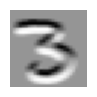

In [28]:
# apply kernel to the full image

rng = range(1, im3_t.shape[0]-1)

top_edge3 = tensor([[apply_kernel(i,j,top_edge_filter) for j in rng] for i in rng])

show_image(top_edge3, cmap="Greys")

Our top edges are black, and bottom edges are white (since they are the opposite of top edges).


We can try with another filter.

<AxesSubplot:title={'center':'left edge'}>

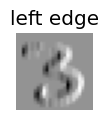

In [32]:
left_edge = tensor([
    [-1, 1, 0],
    [-1, 1, 0],
    [-1, 1, 0],
]).float()

left_edge3 = tensor([[apply_kernel(i,j,left_edge) for j in rng] for i in rng])

show_image(left_edge3, cmap="Greys", title="left edge")

In [35]:
left_edge3[0:10, 0:10]

tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0471,  0.3412, -0.0314,  0.2000,  0.0510,  0.3569, -0.2510, -0.1059],
        [ 0.0000,  0.0000,  0.5882,  0.7961, -0.0314,  0.2000,  0.0510,  0.3569, -0.2510, -0.1059],
        [ 0.0000,  0.0000,  1.4510,  0.9294, -0.0314,  0.2000, -0.0235,  0.1765, -0.2510, -0.1059],
        [ 0.0000,  0.0000,  1.5412,  0.7412, -0.1529,  0.0000, -0.1137, -0.2784,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  1.0000,  0.2863, -0.1529,  0.0000, -0.1137, -0.2784,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.1373,  0.1529, -0.1529,  0.0000, -0.0392, -0.0980,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]])

![](images/output_activation_map.png)


Look at the shape of the result. If the original image has a height of `h` and a width of `w`, how many 3×3 windows can we find? As you can see from the example, there are `h-2` by `w-2` windows, so the image we get has a result as a height of `h-2` and a width of `w-2`.

### Convolutions in PyTorch

In Python it's called `F.conv2d` (F is a fastai import from torch.nn.functional), it includes these params:

- input:: input tensor of shape (minibatch, in_channels, iH, iW)
- weight:: filters of shape (out_channels, in_channels, kH, kW)


Here `iH`, `iW` is the height and width of the image (i.e., 28,28), and `kH`, `kW` is the height and width of our kernel (3,3).

PyTorch can apply a convolution to multiple images at the same time and can apply multiple kernels at the same time.

In [39]:
diag1_edge = tensor([
    [ 0,-1, 1],
    [-1, 1, 0],
    [ 1, 0, 0],
]).float()

diag2_edge = tensor([
    [ 1,-1, 0],
    [ 0, 1,-1],
    [ 0, 0, 1]
]).float()


edge_kernels = torch.stack([left_edge, top_edge_filter, diag1_edge, diag2_edge])
edge_kernels.shape

torch.Size([4, 3, 3])

In [46]:
# To test this, we'll need a DataLoader and a sample mini-batch. Let's use the data block API:

mnist = DataBlock(
    (ImageBlock(cls=PILImageBW), CategoryBlock), 
    get_items=get_image_files, 
    splitter=GrandparentSplitter(),
    get_y=parent_label
)

dls = mnist.dataloaders(path)

xb, yb = first(dls.valid)
xb.shape

torch.Size([64, 1, 28, 28])

One batch contains 64 images, each of 1 channel, with 28×28 pixels

In [ ]:
# By default, fastai puts data on the GPU when using data blocks. Let's move it to the CPU for our examples:

xb, yb = to_cpu(xb), to_cpu(yb)

Currently the shape of our kernels (weights for pytorch) is [4, 3, 3], we need to insert one axis to represent the amount of channels, in this case must be 1 because we're working with black and white images.

In [49]:
# we can use unsqueeze at axis 1

edge_kernels.shape, edge_kernels.unsqueeze(1).shape


(torch.Size([4, 3, 3]), torch.Size([4, 1, 3, 3]))

In [50]:
edge_kernels = edge_kernels.unsqueeze(1)

In [51]:
# apply convolution
batch_features = torch.nn.functional.conv2d(xb, edge_kernels)
batch_features.shape

torch.Size([64, 4, 26, 26])

The output shape shows we gave 64 images in the mini-batch, 4 kernels, and 26×26 edge maps (we started with 28×28 images, but lost one pixel from each side as discussed earlier). We can see we get the same results as when we did this manually:

<AxesSubplot:title={'center':'diag2_edge'}>

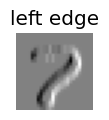

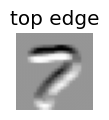

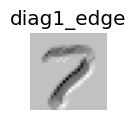

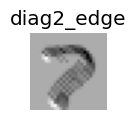

In [53]:
# check filters: left_edge, top_edge, diag1_edge, diag2_edge
show_image(batch_features[0, 0], cmap="Greys", title="left edge")
show_image(batch_features[0, 1], cmap="Greys", title="top edge")
show_image(batch_features[0, 2], cmap="Greys", title="diag1_edge")
show_image(batch_features[0, 3], cmap="Greys", title="diag2_edge")

The most important trick that PyTorch has up its sleeve is that it can use the GPU to do all this work in parallel—that is, applying multiple kernels, to multiple images, across multiple channels.

### Strides and padding

It would be nice to not lose those two pixels on each axis. The way we do that is to add padding, which is simply additional pixels added around the outside of our image (for instace, zeros).

With appropriate padding, we can ensure that the output activation map is the same size as the original image.

![](images/padding.svg)

If we add a kernel of size `ks` by `ks` (with ks an odd number), the necessary padding on each side to keep the same shape is `ks//2`.


So far, when we have applied the kernel to the grid, we have moved it 1 pixel over at a time. But we can jump further; for instance, we could move over 2 pixels after each kernel application. This is known as a `stride-2` convolution.

The most common kernel size in practice is 3×3, and the most common padding is 1. As you'll see, `stride-2` convolutions are useful for decreasing the size of our outputs, and `stride-1` convolutions are useful for adding layers without changing the output size.

![](images/stride_and_padding.png)


In an image of size `h` by `w`, using a padding of 1 and a stride of 2 will give us a result of size `(h+1)//2` by `(w+1)//2`. The general formula for each dimension is `(n + 2*pad - ks)//stride + 1`, where `pad` is the padding, `ks`, the size of our kernel.